In [1]:
import illustris_python as il
import matplotlib.pyplot as plt
from tenet.util import sphMap
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.patheffects as pe
import matplotlib.transforms as transforms
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter, fourier_gaussian
from scipy.stats import ks_2samp, anderson_ksamp
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from scipy import interpolate
import os
import time
import h5py
import rohr_utils as ru 
import random
import six
%matplotlib inline 

plt.style.use('fullpage.mplstyle')
figsizewidth  = 6.902 # the textwidth in inches of MNRAS


In [2]:
def model_2dradprof(data):
    """ 
    compute the model 2D radial profile from a 2D histogram
    based on StackOverflow answer found here: 
    https://stackoverflow.com/questions/21242011/most-efficient-way-to-calculate-radial-profile
    """
    center = [(data.shape[0] - 1.) / 2., (data.shape[1] - 1.) / 2.]
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    
    rpix = np.arange(radialprofile.size)
    radprof_func = interpolate.interp1d(rpix, radialprofile)
    
    model = radprof_func(r)
    
    return model, radprof_func 


In [3]:
indirec = '../Output/L680n8192TNG_subfindGRP_20230916/'
infname = 'central_subfind_L680n8192TNG_tau_all.hdf5'
centrals_taudict = {}
with h5py.File(indirec + infname, 'r') as f:
    group = f['Group']
    for dset_key in group.keys():
        centrals_taudict[dset_key] = group[dset_key][:]
    f.close()
    
haloIDs = centrals_taudict['HostSubhaloGrNr']


In [4]:
indirec = '../Output/L680n8192TNG_subfindGRP_20230916/'
infname = 'subfind_L680n8192TNG_tau_all_gasz0.hdf5'
satellites_taudict = {}
with h5py.File(indirec + infname, 'r') as f:
    group = f['Group']
    for dset_key in group.keys():
        satellites_taudict[dset_key] = group[dset_key][:]
    f.close()

HostSubhaloGrNr = satellites_taudict['HostSubhaloGrNr']
subfindIDs = satellites_taudict['SubfindID']

In [5]:

# load halo's gas cells
sim = 'L680n8192TNG'
basePath = ru.ret_basePath(sim)
snapNum = 99

# load general simulation parameters
header = il.groupcat.loadHeader(basePath, snapNum)
z = header['Redshift']
a = header['Time'] # scale factor
h = header['HubbleParam'] # = 0.6774
boxsize = header['BoxSize'] * a / h
    
gas_ptn = il.util.partTypeNum('gas')

xray_key = 'xray_lum_0.5-2.0kev'

gas_hsml_fact = 1.5
pixel_size = 5. # kpc
smoothing_scale = 300. / pixel_size # keep constant at 200 or 500 kpc
contours_smoothing = 7.5 / pixel_size
boxSizeSim = [boxsize, boxsize, boxsize]
ndims = 3

# open the centrals GRP file, loop over the keys, but only add the dataset for z=0



In [6]:
# load all maps into dictionary 
indirec = '../Output/%s_subfindGRP_20230916/'%sim
infname = 'central_subfind_L680n8192TNG_branches.hdf5'
Lx_maps = {}
with h5py.File(indirec + infname, 'r') as inf:
    for group_key in inf.keys():
        group = inf[group_key]
        Lx_maps[group_key] = {}
        for dset_key in group.keys():
            if 'xray' in dset_key:
                Lx_maps[group_key][dset_key] = group[dset_key][:]
    inf.close()            
central_keys = np.array(list(Lx_maps.keys()))


In [7]:
# load all subhalos in the simulation
subhalo_fields = ['SubhaloMassInRadType', 'SubhaloPos', 'SubhaloMassType']
star_ptn = il.util.partTypeNum('star')

Subhalos = il.groupcat.loadSubhalos(basePath, snapNum, fields=subhalo_fields)
Subhalos_Mstar = Subhalos['SubhaloMassInRadType'][:,star_ptn] * 1.0e10 / h
Subhalos_Pos = Subhalos['SubhaloPos'] * a / h
Subhalos_Mgas = Subhalos['SubhaloMassType'][:,gas_ptn] * 1.0e10 / h

In [8]:
proj = 'xy'
axes = [0,1]

Mstar_lolim = 1.e10 # Msun
Mstar_hilim_frac = 100. # M_star^cent

FoV_fact_rvir = 1.5 # Rvir

size = 3.0e2 # kpc
pixel_size = 5.0 # kpc
x = np.logspace(np.log10(1.), np.log10(size / pixel_size))


In [9]:
subfindID_key = 'subfindID'
dset_key = 'Lxsoft_excess'
mstar_key = 'mstar'
mgas_key = 'mgas'
hcd_phys_key = 'hcd_phys'
hcd_norm_key = 'hcd_norm'
m200c_key = 'm200c'
Lxsoft_excess_label = r'Soft X-ray SB Excess'
control_key = 'control'

figsizewidth  = 6.902 # the textwidth in inches of MNRAS
figsizeratio = 9. / 16.
figsizeheight = figsizewidth * figsizeratio

figsizewidth_fullpage = figsizewidth
figsizeheight_fullpage = figsizewidth_fullpage * figsizeratio
figsizewidth_column = (244. / 508.) * figsizewidth
figsizeheight_column = figsizewidth_column * figsizeratio

def return_Lxsoftexcess_dict(haloID, central_key, 
                             proj=proj, axes=axes,
                             Mstar_lolim=Mstar_lolim, Mstar_hilim_frac=Mstar_hilim_frac,
                             FoV_fact_rvir=FoV_fact_rvir,
                             size=size, pixel_size=pixel_size):
    """
    For the given halo, calculate the radial profile of the soft x-ray SB excess for all
    other subhalos within the FoV. Returns a dictionary of scalars about the satellites
    [subfindID, mstar, mgas, hcd_phys, hcd_norm, m200c] and the radial profiel as a masked array.
    Subhalos that fall outside of the FoV are masked.
    """
    
    result = {}
    group = Lx_maps[central_key]
    
    FoF_Lxsoft = group['xray_lum_0.5-2.0kev_%s'%proj]
    FoF_Lxsoft_smooth = group['xray_lum_0.5-2.0kev_%s_smooth'%proj]
    FoF_Lxsoft_excess = FoF_Lxsoft / FoF_Lxsoft_smooth

    halo = il.groupcat.loadSingle(basePath, snapNum, haloID=haloID)
    M200c = halo['Group_M_Crit200'] * 1.0e10 / h
    R200c = halo['Group_R_Crit200'] * a / h
    halo_pos = halo['GroupPos'] * a / h
    central = il.groupcat.loadSingle(basePath, snapNum, subhaloID=halo['GroupFirstSub'])
    central_Mstar = central['SubhaloMassInRadType'][star_ptn] * 1.0e10 / h

    # conditions for another galaxy to be considered:
    # i) M* > 10^10 and M_star^sat / M_star^cent < 1/10
    # ii) projected host centric distance < 1.5 R200c

    subhalo_indices = ((Subhalos_Mstar > Mstar_lolim) & 
                       ((Subhalos_Mstar / central_Mstar) < Mstar_hilim_frac) &
                       (np.sqrt((Subhalos_Pos[:,axes[0]] - halo_pos[axes[0]])**2 +
                                (Subhalos_Pos[:,axes[1]] - halo_pos[axes[1]])**2) < FoV_fact_rvir * R200c))
    subhaloIDs = np.where(subhalo_indices)[0]
    
    result[subfindID_key] = subhaloIDs
    result[mstar_key] = Subhalos_Mstar[subhalo_indices]
    result[mgas_key] = Subhalos_Mgas[subhalo_indices]
    result[hcd_phys_key] = np.sqrt((Subhalos_Pos[subhalo_indices,axes[0]] - halo_pos[axes[0]])**2 +
                                   (Subhalos_Pos[subhalo_indices,axes[1]] - halo_pos[axes[1]])**2)
    result[hcd_norm_key] = result[hcd_phys_key] / R200c
    result[m200c_key] = np.ones(subhaloIDs.size, M200c.dtype) * M200c

    ys = np.zeros((subhaloIDs.size, x.size), dtype=x.dtype) - 1
    control = ys.copy()
    for subhalo_index, subhaloID in enumerate(subhaloIDs):
        subhalo = il.groupcat.loadSingle(basePath, snapNum, subhaloID=subhaloID)
        SubhaloPos = ru.shift(subhalo['SubhaloPos'] * a / h, halo_pos, boxsize)

        center = [(FoF_Lxsoft_excess.shape[0] - 1.) / 2., (FoF_Lxsoft_excess.shape[1] - 1.) / 2.]
        extent_indices = [int(center[0] + (SubhaloPos[axes][1] - size)/pixel_size), int(center[0] + (SubhaloPos[axes][1] + size)/pixel_size),
                          int(center[1] + (SubhaloPos[axes][0] - size)/pixel_size), int(center[1] + (SubhaloPos[axes][0] + size)/pixel_size)]
        if min(extent_indices) < 0 or max(extent_indices) > FoF_Lxsoft_excess.shape[0]:
            continue
        vals = FoF_Lxsoft_excess[extent_indices[0]:extent_indices[1],extent_indices[2]:extent_indices[3]]
        model, func = model_2dradprof(vals)
        ys[subhalo_index,:] = func(x)

        extent_indices = [extent_indices[2], extent_indices[3], extent_indices[0], extent_indices[1]]
        vals = FoF_Lxsoft_excess[extent_indices[0]:extent_indices[1],extent_indices[2]:extent_indices[3]]
        model, func = model_2dradprof(vals)
        control[subhalo_index,:] = func(x)


    ys = np.ma.masked_values(ys, -1)
    control = np.ma.masked_values(control, -1)
    result[dset_key] = ys
    result[control_key] = control
                             
    return result


def return_stacked_dict(ys, dset, dset_bins):
    """
    Given the tau_dict, dset_key, and dset_dset_bins, bin all subhalos within
    the tau_dict by the dset_key and dset_dset_bins. Then within the stack,
    calculate the medians, 16th, and 84th percentiles of the densities both
    in normalized and physical radial coordinates. Note that this assumes linear
    interpolation between the nonzero density entries. 
    Resulting dictionary takes indices as keys, which lead to another dictionary 
    that takes '50_phys', '16_phys', '84_phys', '50_norm', '16_norm', '84_norm',
    and 'Ngal'. 'Ngal' is an integer, and all other entries are 1D arrays 
    corresponding to the global radii_phys_bincents and radii_norm_bincents 1D arrays.
    """
    
    result_dict = {}
    
    for bin_i in range(len(dset_bins)-1):
        result_dict[bin_i] = {}
        indices = ((dset > dset_bins[bin_i]) &
                   (dset < dset_bins[bin_i+1]))
        
        data = ys[indices,:]
        if data.size == 0:
            result_dict[bin_i]['Ngal'] = 0
            continue

        # initalize the outputs
        result_dict[bin_i]['50_phys'] = np.ma.median(data, axis=0)
        result_dict[bin_i]['16_phys'] = np.percentile(data, 16, axis=0)
        result_dict[bin_i]['84_phys'] = np.percentile(data, 84, axis=0)
        result_dict[bin_i]['mean_phys'] = np.ma.mean(data, axis=0)
        result_dict[bin_i]['std_phys'] = np.ma.std(data, axis=0)

        result_dict[bin_i]['Ngal'] = len(indices[indices])
        
    # finish loop over bins. return to main
    return result_dict


def plot_stacked_dict(ax, stacked_dict,
                      dset, dset_bins, colors, errs=False,
                      statistic='mean', radii='phys', label=None):
    """
    Plot the stacked_dict given the dict, dset_bins, and label.
    If radii=='norm', then use the normalized radial coordinates.
    If radii=='phys', use physical radial coordinates.
    """
    if radii == 'phys':
        x_label = r'Satellite-Centric Distance [kpc]'
    elif radii == 'norm':
        x_label = r'Satellite-Centric Distance [$r/R_{\rm half,\star}$]'
    
    else:
        raise ValueError('invalid radii value %s. Accepted values are norm and phys'%radii)
        
    if len(colors) < len(stacked_dict.keys()):
        raise ValueError('too few colors given')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(x_label)
    #ax.set_ylabel(Lxsoft_excess_label)

    for i, bin_key in enumerate(stacked_dict.keys()):
        if stacked_dict[bin_key]['Ngal'] == 0:
            continue
        color = colors[i]
        Ngal = stacked_dict[bin_key]['Ngal']
        y_mean = stacked_dict[bin_key]['mean_%s'%radii]
        y_std = stacked_dict[bin_key]['std_%s'%radii]
        y_50 = stacked_dict[bin_key]['50_%s'%radii]
        y_16 = stacked_dict[bin_key]['16_%s'%radii]
        y_84 = stacked_dict[bin_key]['84_%s'%radii]
        
        if label == 'control':
            label = r'Control (%d)'%Ngal
        elif label:
            label = r'$[%.1f, %.1f)\ (%d)$'%(dset_bins[i], dset_bins[i+1], Ngal)
        else:
            label = None

        x_plot = x * pixel_size
        
        if statistic == 'both':
            ax.plot(x_plot, y_mean, '-', color=color, label=label, lw=4)
            ax.plot(x_plot, y_50, '--', color=color, lw=2)
        elif statistic == 'mean':
            ax.plot(x_plot, y_mean, '-', color=color, label=label, lw=4)
            if errs:
                ax.fill_between(x_plot, y_mean - y_std, y_mean + y_std, color=color, alpha=0.1)
        elif statistic == 'median':
            ax.plot(x_plot, y_50, '--', color=color, label=label, lw=2)
            if errs:
                ax.fill_between(x_plot, y_16, y_84, color=color, alpha=0.1)
        else:
            raise ValueError('Input statistic %s is currently not supported. Try "mean", "median", or "both".'%statistic)
        
    ax.set_ylim(5e-1, 5e1)
    
    return ax


def plot_stacked_dict_multipanel(result, haloID, statistic='mean'):
    
    fig, axs = plt.subplots(3, 1, figsize=(figsizewidth, figsizewidth*2))
    
    ys = result[dset_key]

    ### use artificial bins and dset for the control to plot everything 
    control = result[control_key]
    control_dset = np.zeros(control.shape[0]) + 0.5
    control_bins = [0, 1]
    control_colors = ['black']

    control_stacked_dict = return_stacked_dict(control, control_dset, control_bins)

    
    if haloID == 'all':
        axs[0].set_title('TNG-Cluster All Clusters (352)')
    else:
        axs[0].set_title('TNG-Cluster $z=0$ haloID %s \n satellite soft-xray SB excess'%haloID)
    
    ax = axs[0]
    key = m200c_key
    colors = ['purple', 'orange', 'yellow']
    label = r'$\log_{10}[M_{\rm 200c}^{\rm host} / {\rm M_\odot}] \in$'
    bins = [14.3, 14.7, 15.0, 15.44]
    dset = result[key].copy()
    dset = np.log10(dset)

    stacked_dict = return_stacked_dict(ys, dset, bins)
    ax = plot_stacked_dict(ax, control_stacked_dict, control_dset, control_bins, control_colors, statistic=statistic, label='control', radii='phys', errs=False)
    ax = plot_stacked_dict(ax, stacked_dict, dset, bins, colors, statistic=statistic, label=True, radii='phys')
    ax.legend(title=label)    
    
    """
    ax = axs[1]
    key = mgas_key
    colors = ['violet', 'mediumpurple', 'indigo']
    label = r'$\log_{10}[M_{\rm gas}^{\rm sat} / {\rm M_\odot}] \in$'
    bins = [9.0, 10., 11., 14.0]
    dset = result[key].copy()
    dset[dset == 0] = 1.1e6
    dset = np.log10(dset)

    stacked_dict = return_stacked_dict(ys, dset, bins)
    ax = plot_stacked_dict(ax, control_stacked_dict, control_dset, control_bins, control_colors, statistic=statistic, label='control', radii='phys')
    ax = plot_stacked_dict(ax, stacked_dict, dset, bins, colors, statistic=statistic, label=True, radii='phys')
    ax.legend(title=label)    
    """    

    ax = axs[1]
    key = mstar_key
    colors = ['bisque', 'orange', 'darkgoldenrod']
    bins = [10.0, 10.75, 11.5, 12.5]
    label = r'$\log_{10}[M_{\star}^{\rm sat} / {\rm M_\odot}] \in$'
    dset = np.log10(result[key].copy())    
    
    stacked_dict = return_stacked_dict(ys, dset, bins)
    ax = plot_stacked_dict(ax, control_stacked_dict, control_dset, control_bins, control_colors, statistic=statistic, label='control', radii='phys')
    ax = plot_stacked_dict(ax, stacked_dict, dset, bins, colors, statistic=statistic, label=True, radii='phys')
    ax.legend(title=label)    
    
    ax = axs[2]
    key = hcd_norm_key
    colors = ['palegreen', 'green', 'darkgreen']
    bins = [0.0, 0.5, 1.0, 1.501]
    label = r'proj. $d_{\rm sat}^{\rm host} / R_{\rm 200c}^{\rm host} \in$'
    dset = result[key].copy()
    
    stacked_dict = return_stacked_dict(ys, dset, bins)
    ax = plot_stacked_dict(ax, control_stacked_dict, control_dset, control_bins, control_colors, statistic=statistic, label='control', radii='phys')
    ax = plot_stacked_dict(ax, stacked_dict, dset, bins, colors, statistic=statistic, label=True, radii='phys')
    ax.legend(title=label)    
    
    return fig, axs


In [10]:
all_halos = {}

haloIDs_short = haloIDs[:1]

for group_index, haloID in enumerate(haloIDs_short):
    central_key = central_keys[group_index]
    all_halos[haloID] = return_Lxsoftexcess_dict(haloID, central_key)

In [11]:
all_halos = {}

for group_index, haloID in enumerate(haloIDs):
    central_key = central_keys[group_index]
    all_halos[haloID] = return_Lxsoftexcess_dict(haloID, central_key)
    
everything = {}
largeN = int(1e6)
group = all_halos[haloIDs[0]]
for key in group.keys():
    if key == dset_key or key == control_key:
        everything[key] = np.ma.zeros((largeN, group[key].shape[1]), dtype=group[key].dtype) - 1
    else:
        everything[key] = np.zeros(largeN, group[key].dtype) - 1.
        
Ntotal = 0
for halo_index, haloID in enumerate(all_halos.keys()):
    group = all_halos[haloID]
    Ngal = group[mstar_key].size
    for key in group.keys():
        everything[key][Ntotal:Ntotal+Ngal] = group[key]
    Ntotal += Ngal
    
    # at the end, trim the result back down
    if halo_index == len(all_halos.keys()) - 1:
        for key in group.keys():
            everything[key] = everything[key][:Ntotal]
    
# double check that there are no -1s.
for key in everything.keys():
    if np.ma.any(everything[key] == -1):
        print(key)
        raise ValueError('Warning, there are still -1s.')

In [12]:
savefig=False
direc_list = ['../Figures/TNGCluster/',
              '../Papers/Rohretal_TNGCluster_MassiveSatelliteCGM/figures/']

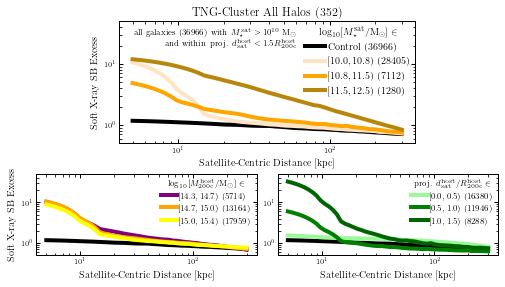

In [13]:
result = everything
haloID = 'all'
statistic='mean'
dset_key = 'Lxsoft_excess'


fig = plt.figure(figsize=(figsizewidth, figsizeheight))
gs0 = gridspec.GridSpec(2, 6, figure=fig, height_ratios=(3,2))

gs_top = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0,1:-1])

ax_top = fig.add_subplot(gs_top[0,0])

ys = result[dset_key]
### use artificial bins and dset for the control to plot everything 
control = result[control_key]
control_dset = np.zeros(control.shape[0]) + 0.5
control_bins = [0, 1]
control_colors = ['black']
control_stacked_dict = return_stacked_dict(control, control_dset, control_bins)

ax = ax_top
key = mstar_key
colors = ['bisque', 'orange', 'darkgoldenrod']
bins = [10.0, 10.75, 11.5, 12.5]
label = r'$\log_{10}[M_{\star}^{\rm sat} / {\rm M_\odot}] \in$'
dset = np.log10(result[key].copy())    

stacked_dict = return_stacked_dict(ys, dset, bins)
ax = plot_stacked_dict(ax, control_stacked_dict, control_dset, control_bins, control_colors, statistic=statistic, label='control', radii='phys')
ax = plot_stacked_dict(ax, stacked_dict, dset, bins, colors, statistic=statistic, label=True, radii='phys')
ax.legend(title=label) 
ax.set_ylabel(Lxsoft_excess_label)

text = (r'all galaxies (%d) with $M_{\star}^{\rm sat} >10^{10}\, {\rm M_\odot}$'%(control_stacked_dict[0]['Ngal']) + '\n' +  
        r'and within proj. $d_{\rm sat}^{\rm host} < 1.5 R_{\rm 200c}^{\rm host}$')
ax.text(0.05, 0.95, text, ha='left', va='top', ma='right', transform=ax.transAxes, size='small')


if haloID == 'all':
    ax_top.set_title('TNG-Cluster All Halos (352)')
else:
    ax_top.set_title('TNG-Cluster $z=0$ haloID %s \n satellite soft-xray SB excess'%haloID)

gs_bot = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[1,:])
 
ax0 = fig.add_subplot(gs_bot[0])

ax = ax0
key = m200c_key
colors = ['purple', 'orange', 'yellow']
label = r'$\log_{10}[M_{\rm 200c}^{\rm host} / {\rm M_\odot}] \in$'
bins = [14.3, 14.7, 15.0, 15.44]
dset = result[key].copy()
dset = np.log10(dset)
stacked_dict = return_stacked_dict(ys, dset, bins)
ax = plot_stacked_dict(ax, control_stacked_dict, control_dset, control_bins, control_colors, statistic=statistic, radii='phys', errs=False)
ax = plot_stacked_dict(ax, stacked_dict, dset, bins, colors, statistic=statistic, label=True, radii='phys')
ax.legend(title=label, fontsize='small', title_fontsize='small', frameon=False, ncol=1)    
ax.set_ylabel(Lxsoft_excess_label)


ax1 = fig.add_subplot(gs_bot[1], sharey=ax0)
"""
ax = ax1
key = mgas_key
colors = ['violet', 'mediumpurple', 'indigo']
label = r'$\log_{10}[M_{\rm gas}^{\rm sat} / {\rm M_\odot}] \in$'
bins = [9.0, 10., 11., 14.0]
dset = result[key].copy()
dset[dset == 0] = 1.1e6
dset = np.log10(dset)
stacked_dict = return_stacked_dict(ys, dset, bins)
ax = plot_stacked_dict(ax, control_stacked_dict, control_dset, control_bins, control_colors, statistic=statistic, label='control', radii='phys')
ax = plot_stacked_dict(ax, stacked_dict, dset, bins, colors, statistic=statistic, label=True, radii='phys')
ax.legend(title=label)    

ax2 = fig.add_subplot(gs_bot[2], sharey=ax0)

ax = ax2   
"""
ax = ax1
key = hcd_norm_key
colors = ['palegreen', 'green', 'darkgreen']
bins = [0.0, 0.5, 1.0, 1.501]
label = r'proj. $d_{\rm sat}^{\rm host} / R_{\rm 200c}^{\rm host} \in$'
dset = result[key].copy()

stacked_dict = return_stacked_dict(ys, dset, bins)
ax = plot_stacked_dict(ax, control_stacked_dict, control_dset, control_bins, control_colors, statistic=statistic, radii='phys')
ax = plot_stacked_dict(ax, stacked_dict, dset, bins, colors, statistic=statistic, label=True, radii='phys')
ax.legend(title=label, fontsize='small', title_fontsize='small', frameon=False, ncol=1)    

if savefig:
    fname = '%s_allhalos_allsubhalos_%s_%s_%s_multipanel.pdf'%(sim, dset_key, proj, statistic)
    for direc in direc_list:
        fig.savefig(direc + fname, bbox_inches='tight')


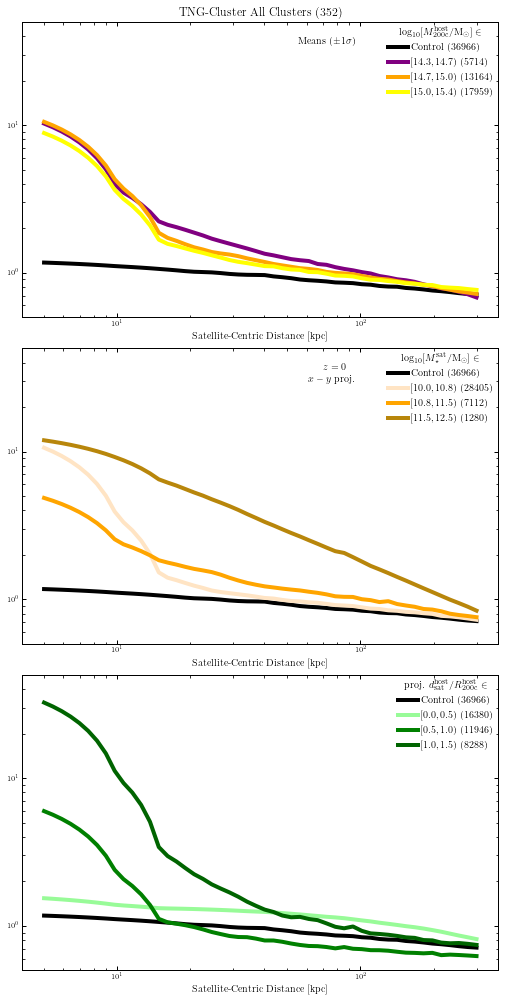

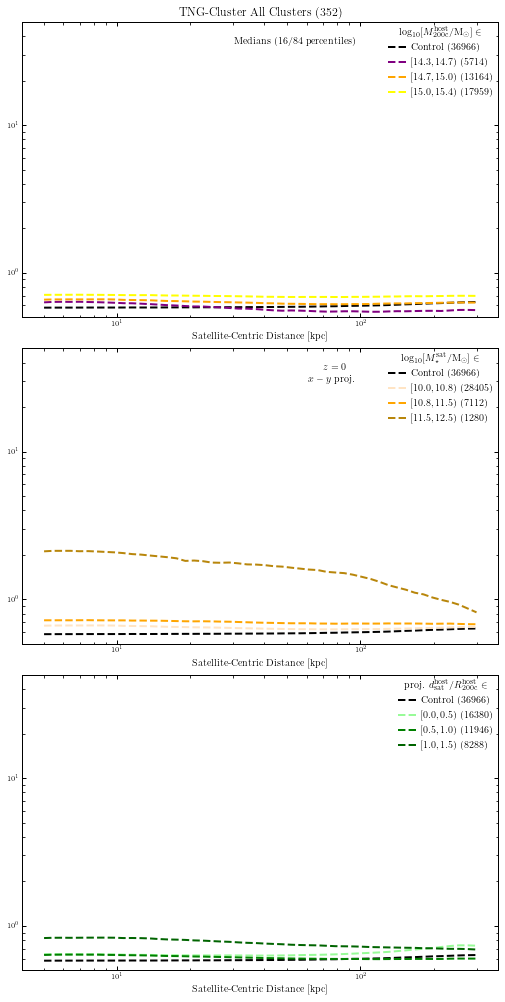

In [14]:
statistic='mean'
fig, axs = plot_stacked_dict_multipanel(everything, 'all', statistic=statistic)
axs[0].text(0.7, 0.95, r'Means ($\pm1\sigma$)', ha='right', va='top', ma='left', transform=axs[0].transAxes)
axs[1].text(0.7, 0.95, r'$z=0$ \\ $x-y$ proj.', ha='right', va='top', ma='left', transform=axs[1].transAxes)
if savefig:
    fname = '%s_allhalos_allsubhalos_%s_%s_%s_multipanel.pdf'%(sim, dset_key, proj, statistic)
    for direc in direc_list:
        fig.savefig(direc + fname, bbox_inches='tight')

statistic = 'median'
fig, axs = plot_stacked_dict_multipanel(everything, 'all', statistic=statistic)
axs[0].text(0.7, 0.95, r'Medians (16/84 percentiles)', ha='right', va='top', ma='left', transform=axs[0].transAxes)
axs[1].text(0.7, 0.95, r'$z=0$ \\ $x-y$ proj.', ha='right', va='top', ma='left', transform=axs[1].transAxes)
if savefig:
    fname = '%s_allhalos_allsubhalos_%s_%s_%s_multipanel.pdf'%(sim, dset_key, proj, statistic)
    for direc in direc_list:
        fig.savefig(direc + fname, bbox_inches='tight')

In [83]:
cmap = mpl.cm.get_cmap('cubehelix').copy()
Lx_imshow_kwargs = dict(cmap=cmap, norm=mpl.colors.LogNorm(vmin=1.0e0, vmax=1.0e5), origin='lower')
Lxsoft_label = r'Soft X-ray [0.5-2.0 keV] Surface Brightness [${\rm L_{\odot}\, kpc}^{-2}$]'
cbar_kwargs = dict(extend='both', label=Lxsoft_label)
Lsun_conversion = (1.0e30) / (3.8334e33) # Lsun 

satellite_size = 3.0e2 # kpc
length = 1.0e2 # kpc

def add_Lxsoft_map(ax, group_index, subhaloID):
    """
    Draw the fixed scale satellite Lx-soft SB map onto the ax.
    Return the ax.
    """

    group = Lx_maps[central_keys[group_index]]
    haloID = haloIDs[group_index]
    sort_indices = np.argsort(all_halos[haloID][mgas_key])[::-1]
    #subhaloID = all_halos[haloID]['subfindID'][sort_indices][subhalo_index]

    FoF_Lxsoft = group['xray_lum_0.5-2.0kev_%s'%proj] * Lsun_conversion
    FoF_Lxsoft_smooth = group['xray_lum_0.5-2.0kev_%s_smooth'%proj] * Lsun_conversion

    halo = il.groupcat.loadSingle(basePath, snapNum, haloID=haloID)
    R200c = halo['Group_R_Crit200'] * a / h
    halo_pos = halo['GroupPos'] * a / h

    # we start by ignoring the z axis and a pixel scale of 1kpc
    boxSizeImg = [3.*R200c, 3.*R200c] # kpc
    boxCen = halo_pos[axes]

    Subhalo = il.groupcat.loadSingle(basePath, snapNum, subhaloID=subhaloID)
    SubhaloPos = ru.shift(Subhalo['SubhaloPos'] * a / h, halo_pos, boxsize)
    subhalopos_xy = SubhaloPos[axes]
    dsathost_proj = np.sqrt(SubhaloPos[0]**2 + SubhaloPos[1]**2) / R200c
    Mstar_sat = Subhalo['SubhaloMassInRadType'][star_ptn] * 1.0e10 / h
    M200c_host = halo['Group_M_Crit200'] * 1.0e10 / h
    
    # draw a square around the satellite, and include the zoom lines
    xy = (subhalopos_xy[0] - satellite_size, subhalopos_xy[1] - satellite_size)
    height = satellite_size*2
    width = satellite_size*2

    center = [(FoF_Lxsoft.shape[0] - 1) / 2., (FoF_Lxsoft.shape[1] - 1.) / 2.]
    extent_indices = [int(round(center[0] + (subhalopos_xy[1] - satellite_size)/pixel_size)),
                      int(round(center[0] + (subhalopos_xy[1] + satellite_size)/pixel_size)),
                      int(round(center[1] + (subhalopos_xy[0] - satellite_size)/pixel_size)),
                      int(round(center[1] + (subhalopos_xy[0] + satellite_size)/pixel_size))]
    extent_satellite = [-satellite_size, satellite_size, -satellite_size, satellite_size]

    vals = FoF_Lxsoft[extent_indices[0]:extent_indices[1],extent_indices[2]:extent_indices[3]]
    Lxsoft_tot = vals.sum() * pixel_size * pixel_size # Lsun 
    img = ax.imshow(vals, extent=extent_satellite, **Lx_imshow_kwargs)

    x0 = - satellite_size + (satellite_size*0.175) # kpc
    y0 = satellite_size - (satellite_size*0.1) # kpc
    ax.plot([x0, x0+length], [y0, y0], color='black', marker='None', ls='-', path_effects=[pe.Stroke(linewidth=3, foreground='w'), pe.Normal()])
    text = ax.text(x0, y0-(satellite_size * 0.1), '%d kpc'%(length), ha='left', va='top', fontsize='xx-small', color='black')
    text.set_path_effects([pe.Stroke(foreground='white', linewidth=0.5),
                           pe.Normal()])
    ax.set_xticks([])
    ax.set_yticks([])
    levels = [1., 2., 5., 10.]
    colors = ['lightgray', 'darkgray', 'tab:gray', 'black']
    colors = ['tab:gray', 'darkgray', 'lightgray', 'white']
    
    text = ax.text(0.025, -0.1, r'snap 99, $z=0$ \\ HostID %d \\ SubfindID: %d'%(haloID, subhaloID), transform=ax.transAxes, fontsize='xx-small', va='bottom', ha='left', ma='left')
    text.set_path_effects([pe.Stroke(foreground='white', linewidth=0.5),
                           pe.Normal()])
    
    text = (r'\['
            r'\begin{split}'
            r'{\rm proj.}\, d_{\rm sat}^{\rm host} = %.1f R_{\rm 200c} &\\'%dsathost_proj + 
            r'\lg M_{\rm 200c}^{\rm host} = %.1f &\\'%np.log10(M200c_host) + 
            r'\lg M_\star^{\rm sat} = %.1f &\\'%np.log10(Mstar_sat) +
            r'\lg L_{\rm 0.5-2.0keV}^{\rm FoV} = %.1f &\\'%np.log10(Lxsoft_tot) +
            r'\end{split}'
            r'\]')
    
    #text = r'proj. $d_{\rm sat}^{\rm host} = %.1f\, R_{\rm 200c}^{\rm host}$ \\ $\log_{10}[M_{\rm 200c} / {\rm M_\odot}] = %.1f$'%(dsathost_proj, np.log10(M200c_host))
    text = ax.text(1.2, 1.05, text,
                  transform=ax.transAxes, fontsize='xx-small', va='top', ha='right', ma='right')
    text.set_path_effects([pe.Stroke(foreground='white', linewidth=0.5),
                           pe.Normal()])    
    
    """
    text = (r'\['
            r'\begin{split}'
            r'\lg M_{\star}^{\rm sat} = %.1f &\\'%np.log10(Mstar_sat) + 
            r'\lg L_{\rm 0.5-2.0keV}^{\rm FoV} = %.1f &\\'%np.log10(Lxsoft_tot) + 
            r'\end{split}'
            r'\]')
    
    #text = r'$\log_{10}[M_{\star}^{\rm sat} / {\rm M_\odot}] = %.1f$ \\ $\log_{10}[L_{\rm 0.5-2.0keV}^{\rm FoV} / L_{\odot}\, {\rm kpc}^{-2}] = %.1f$'%(np.log10(Mstar_sat), np.log10(Lxsoft_tot))
    text = ax.text(1.2, 0.025, text,
                  transform=ax.transAxes, fontsize='xx-small', va='bottom', ha='right', ma='right')
    text.set_path_effects([pe.Stroke(foreground='white', linewidth=0.5),
                           pe.Normal()])   
    """
    #vals_smoothed = gaussian_filter(vals, contours_smoothing)
    #ax.contour(vals_smoothed, levels=[1, 2., 5., 10.], colors=colors, extent=extent_satellite)
    
    return ax, img

/tmp/ipykernel_6620/3822391106.py:31: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(wspace=0, hspace=0)


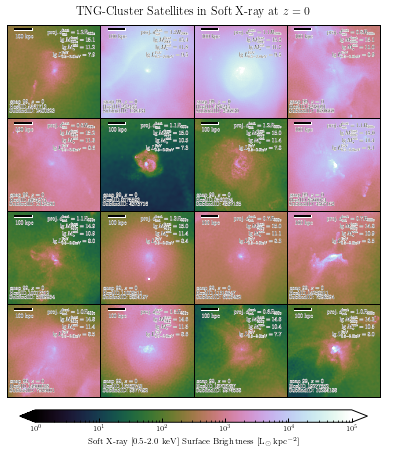

In [104]:
group_indices =   [ 33,   1,   2,  20,
                    28,  75,  80,  80,
                   100, 115, 120, #150,
                   176, 190, 264, 310,
                   340, 351]
subhalo_indices = [ 20,   0,   0,  11,
                    33,   0,   0,   1,
                     1,   0,   3,   #5,
                     1,   0,   0,   3,
                     0,   0]

subfindIDs = [2400623, 138434, 256830, 1680668,
              2132590, 4373716, 4567165, 4567162,
              5309934, 5834197, 6003462, 7596594,
              7929001, 9377482, 9974568, 10284188]

fig, axs = plt.subplots(4, 4, figsize=(figsizewidth,figsizewidth))
for i, ax in enumerate(axs.flatten()):
    group_index = group_indices[i]
    subhalo_index = subhalo_indices[i]
    subfindID = subfindIDs[i]
    ax, img = add_Lxsoft_map(ax, group_index, subfindID)
    
cax = fig.add_axes([0.15, 0.075, 0.7, 0.025])
cbar = fig.colorbar(img, cax=cax, orientation='horizontal', extend='both')
cbar.set_label(Lxsoft_label, fontsize='small')
cbar.ax.tick_params(labelsize='x-small')

fig.suptitle(r'TNG-Cluster Satellites in Soft X-ray at $z=0$', y=0.911)

fig.subplots_adjust(wspace=0, hspace=0)

if savefig:
    fname = '%s_satellite_%s_mosaic.pdf'%(sim, xray_key)
    fig.savefig(direc + fname, bbox_inches='tight', dpi=600)


10.442716


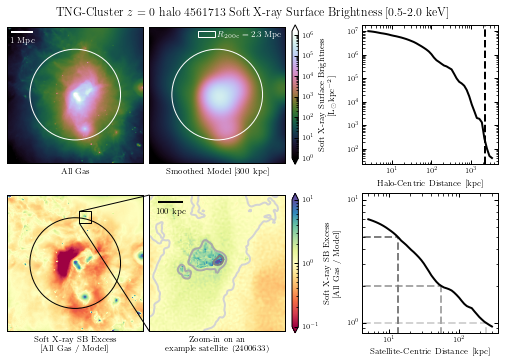

In [17]:
group_index = 33
subhalo_index = 49
#subhalo_index = 70
group = Lx_maps[central_keys[group_index]]
haloID = haloIDs[group_index]
sort_indices = np.argsort(all_halos[haloID][mgas_key])[::-1]
subhaloID = all_halos[haloID]['subfindID'][sort_indices][subhalo_index]
#subhaloID = 2400681
print(np.log10(all_halos[haloID][mgas_key][sort_indices][subhalo_index]))

proj = 'xy'
FoF_Lxsoft = group['xray_lum_0.5-2.0kev_%s'%proj] * Lsun_conversion 

FoF_Lxsoft_smooth = group['xray_lum_0.5-2.0kev_%s_smooth'%proj] * Lsun_conversion

halo = il.groupcat.loadSingle(basePath, snapNum, haloID=haloID)
R200c = halo['Group_R_Crit200'] * a / h
halo_pos = halo['GroupPos'] * a / h

# we start by ignoring the z axis and a pixel scale of 1kpc
axes = [0,1]
boxSizeImg = [3.*R200c, 3.*R200c] # kpc
boxCen = halo_pos[axes]

# now plot data, model, zoom-in and rad prof
fig, big_axs = plt.subplots(2, 3, figsize=(figsizewidth, figsizewidth/1.4))

fig.suptitle(r'TNG-Cluster $z=0$ halo %d Soft X-ray Surface Brightness [0.5-2.0 keV]'%(haloID))

cmap = mpl.cm.get_cmap('cubehelix').copy()
extent = [-boxSizeImg[0]/2., boxSizeImg[0]/2., -boxSizeImg[1]/2., boxSizeImg[1]/2.]
vmax = np.percentile(FoF_Lxsoft, 99.9)
Lx_imshow_kwargs = dict(extent=extent, cmap=cmap, norm=mpl.colors.LogNorm(vmin=1.0e0, vmax=vmax), origin='lower')
Lxsoft_label = 'Soft X-ray Surface Brightness \n' + r'[${\rm L_\odot kpc^{-2}}$]'
cbar_kwargs = dict(extend='both', label=Lxsoft_label)

### top row
axs = big_axs[0,:]

# plot the FoF ddata
ax = axs[0]
img = ax.imshow(FoF_Lxsoft, **Lx_imshow_kwargs)
ax.set_xticks([])
ax.set_yticks([])

# add a circle at R200c
circ_kwargs = dict(fill=False, color='white', lw=1.0)
circ_R200c = patches.Circle((0.0,0.0), R200c, linestyle='-', **circ_kwargs,
                            label=r'$R_{\rm 200c} = %#1.1f\, {\rm Mpc}$'%float(R200c / 1.0e3))
ax.add_patch(circ_R200c)

# add a length scale
x0 = -boxSizeImg[0]/2. + (boxSizeImg[0]/2. * 0.075)# kpc
y0 = boxSizeImg[1]/2. -(boxSizeImg[1]/2. * 0.075)# kpc
length = 1.0e3 # kpc
ax.plot([x0, x0+length], [y0, y0], color='white', marker='None', ls='-')
ax.text(x0+length/2., y0-(boxSizeImg[1]/2. * 0.075), '%d Mpc'%(length/1.0e3), ha='center', va='top', fontsize='small', color='white')
ax.set_xlabel(r'All Gas', fontsize='small')


ax = axs[1]
img = ax.imshow(FoF_Lxsoft_smooth, **Lx_imshow_kwargs)
cbar = fig.colorbar(img, ax=ax, extend='both')
cbar.set_label(Lxsoft_label, fontsize='small')
ax.set_xticks([])
ax.set_yticks([])
circ_R200c = patches.Circle((0.0,0.0), R200c, linestyle='-', **circ_kwargs,
                            label=r'$R_{\rm 200c} = %#1.1f\, {\rm Mpc}$'%float(R200c / 1.0e3))
ax.add_patch(circ_R200c)
ax.legend(loc='upper right', labelcolor='white', fontsize='small')
ax.set_xlabel(r'Smoothed Model [%d kpc]'%(int(smoothing_scale * pixel_size)), fontsize='small')

# plot the radial profile
FoF_Lxsoft_RP, FoF_Lxsoft_RP_func = model_2dradprof(FoF_Lxsoft)
FoF_Lxsoft_smooth_RP, FoF_Lxsoft_smooth_RP_func = model_2dradprof(FoF_Lxsoft_smooth)
ax = axs[2]
x = np.logspace(np.log10(1./2.), np.log10(boxSizeImg[0]/2. / pixel_size))
ax.plot(x * pixel_size, FoF_Lxsoft_RP_func(x), '-')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'Halo-Centric Distance [kpc]', fontsize='small')
ax.axvline(R200c, color='black', ls='--', marker='None')
#ax.set_ylabel(Lxsoft_label)

### bottom row
axs = big_axs[1,:]

FoF_LXsoftexcess = (FoF_Lxsoft / FoF_Lxsoft_smooth)

vmax = np.percentile(FoF_LXsoftexcess, 99.9)
vmax = 10

ax = axs[0]
norm = mpl.colors.LogNorm(vmin=10.**(-np.log10(vmax)), vmax=vmax)
excess_kwargs = dict(cmap='Spectral', origin='lower', norm=norm)
img = ax.imshow(FoF_LXsoftexcess, extent=extent, **excess_kwargs)
cbar = fig.colorbar(img, ax=axs[1], extend='both')
LXsoftexcess_label = 'Soft X-ray SB Excess \n [All Gas / Model]'
cbar.set_label(LXsoftexcess_label, fontsize='small')

# add the R200c circle
circ_R200c = patches.Circle((0.0,0.0), R200c, linestyle='-', color='black', fill=False)
ax.add_patch(circ_R200c)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(LXsoftexcess_label, fontsize='small')

# add a rectangle around the subhalo

Subhalo = il.groupcat.loadSingle(basePath, snapNum, subhaloID=subhaloID)
SubhaloPos = ru.shift(Subhalo['SubhaloPos'] * a / h, halo_pos, boxsize)
subhalopos_xy = SubhaloPos[axes]

satellite_size = 3.0e2 # kpc

# draw a square around the satellite, and include the zoom lines
xy = (subhalopos_xy[0] - satellite_size, subhalopos_xy[1] - satellite_size)
height = satellite_size*2
width = satellite_size*2

rect = patches.Rectangle(xy, width, height, fill=False)
ax.add_patch(rect)

# add the zoom lines 

ax1 = axs[0]
ax2 = axs[1]
con = ConnectionPatch(xyA=xy, coordsA=ax1.transData,
                      xyB=(0,0), coordsB=ax2.transAxes)
fig.add_artist(con)

xy2 = (xy[0], xy[1] + height)
con = ConnectionPatch(xyA=xy2, coordsA=ax1.transData,
                      xyB=(0,1), coordsB=ax2.transAxes)
fig.add_artist(con)

ax = axs[1]
center = [(FoF_LXsoftexcess.shape[0] - 1) / 2., (FoF_LXsoftexcess.shape[1] - 1.) / 2.]
extent_indices = [int(round(center[0] + (subhalopos_xy[1] - satellite_size)/pixel_size)),
                  int(round(center[0] + (subhalopos_xy[1] + satellite_size)/pixel_size)),
                  int(round(center[1] + (subhalopos_xy[0] - satellite_size)/pixel_size)),
                  int(round(center[1] + (subhalopos_xy[0] + satellite_size)/pixel_size))]
extent_satellite = [-satellite_size, satellite_size, -satellite_size, satellite_size]

vals = FoF_LXsoftexcess[extent_indices[0]:extent_indices[1],extent_indices[2]:extent_indices[3]]
img = ax.imshow(vals, extent=extent_satellite, **excess_kwargs)

x0 = - satellite_size + (satellite_size*0.15) # kpc
y0 = satellite_size - (satellite_size*0.1) # kpc
length = 1.0e2 # kpc
ax.plot([x0, x0+length], [y0, y0], color='black', marker='None', ls='-')
ax.text(x0+length/2., y0-(satellite_size * 0.1), '%d kpc'%(length), ha='center', va='top', fontsize='small', color='black')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Zoom-in on an \n example satellite (%d)'%subhaloID, fontsize='small')
levels = [1., 2., 5., 10.]
colors = ['lightgray', 'darkgray', 'tab:gray', 'black']

vals_smoothed = gaussian_filter(vals, contours_smoothing)
ax.contour(vals_smoothed, levels=[1, 2., 5., 10.], colors=colors, extent=extent_satellite)

ax = axs[2]
model, func = model_2dradprof(vals_smoothed)
x = np.logspace(np.log10(1.), np.log10(satellite_size / pixel_size))
ax.plot(x * pixel_size, func(x), '-')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'Satellite-Centric Distance [kpc]', fontsize='small')
intercepts = np.interp(levels, func(np.arange(satellite_size / pixel_size))[::-1], np.arange(satellite_size / pixel_size)[::-1]) * pixel_size
ax.hlines(levels, 0, intercepts, colors=colors, ls='--')
ax.vlines(intercepts, 0, levels, colors=colors, ls='--')

if savefig:
    fname = '%s_snap099_haloID%08d_subahlo%08d_%s_multipanel.pdf'%(sim, haloID, subhaloID, proj)
    for direc in direc_list:
        fig.savefig(direc + fname, bbox_inches='tight', dpi=600)


In [18]:


# load all maps into dictionary 
indirec = '../Output/%s_subfindGRP_20230916/'%sim
infname = 'central_subfind_L680n8192TNG_branches.hdf5'
Lx_maps = {}
with h5py.File(indirec + infname, 'r') as inf:
    for group_key in inf.keys():
        group = inf[group_key]
        Lx_maps[group_key] = {}
        for dset_key in group.keys():
            if 'xray' in dset_key:
                Lx_maps[group_key][dset_key] = group[dset_key][:]
    inf.close()            
central_keys = np.array(list(Lx_maps.keys()))

In [19]:
# load the soft x-ray luminosities
Lx_key = 'xray_lum_0.5-2.0kev'
Lx_direc = '/vera/ptmp/gc/dnelson/sims.TNG/L680n8192TNG/data.files/cache/'
Lx_fname = 'cached_gas_xray_lum_0.5-2.0kev_99.hdf5'
with h5py.File(Lx_direc + Lx_fname, 'r') as Lx_f:
    Lx_all = Lx_f[Lx_key][:]

In [105]:
Lx_map_key = Lx_key + '_' + 'xy'
Lx_map_4k_key = Lx_map_key + '_4k'
Lx_map_4k_key_onlyBCG = Lx_map_4k_key + '_onlyBCG'
Lx_map_4k_key_noBCG_nofuzz =  Lx_map_4k_key + '_noBCG_nofuzz'
Lx_map_4k_key_onlyFuzz = Lx_map_4k_key + '_onlyFuzz'

gas_fields = ['Masses', 'Coordinates', 'Density']

gas_hsml_fact = 1.5
pixel_size = 5. # kpc
smoothing_scale = 300. / pixel_size # keep constant at 300 kpc

Npixels_4k = 4096

def add_Lx_maps(central_key, haloID):
    """
    given the central_key and haloID, load all gas cells and compute the soft x-ray SB maps
    for just the BCG and everything except the BCG. then add to the Lx_maps dictionary
    """

    # load all gas cells
    total_gas_cells = il.snapshot.loadOriginalZoom(basePath, snapNum, haloID, gas_ptn, fields=gas_fields)
    total_gas_cells[Lx_key] = np.zeros(total_gas_cells['count'], dtype=float) - 1.

    halo = il.snapshot.loadSingle(basePath, snapNum, haloID=haloID)

    subset_GroupFirstSub = il.snapshot.getSnapOffsets(basePath, snapNum, halo['GroupFirstSub'], "Subhalo")

    ### find the relevant indices to load the Lx dataset
    # load fuzz length, compute offset, call loadSubset                                                                     
    subset = il.snapshot.getSnapOffsets(basePath, snapNum, haloID, "Group")

    # identify original halo ID and corresponding index
    assert 'GroupOrigHaloID' in halo, 'Error: loadOriginalZoom() only for the TNG-Cluster simulation.'
    orig_index = np.where(subset['HaloIDs'] == halo['GroupOrigHaloID'])[0][0]

    # (1) load all FoF particles/cells
    length_FoF = subset['GroupsTotalLengthByType'][orig_index, gas_ptn]
    start_FoF = subset['GroupsSnapOffsetByType'][orig_index, gas_ptn]
    total_gas_cells[Lx_key][:length_FoF] = Lx_all[start_FoF:start_FoF+length_FoF]

    # (2) load all non-FoF particles/cells
    length_fuzz = subset['OuterFuzzTotalLengthByType'][orig_index, gas_ptn]
    start_fuzz = subset['OuterFuzzSnapOffsetByType'][orig_index, gas_ptn]
    total_gas_cells[Lx_key][length_FoF:] = Lx_all[start_fuzz:start_fuzz+length_fuzz]

    assert total_gas_cells[Lx_key].min() >= 0, 'Error: not all Lx array indices were set.'

    onlyBCG_gas_cells = {}
    for key in total_gas_cells.keys():
        if key == 'count':
            onlyBCG_gas_cells[key] = subset_GroupFirstSub['lenType'][gas_ptn]
        else:
            onlyBCG_gas_cells[key] = total_gas_cells[key][:subset_GroupFirstSub['lenType'][gas_ptn]]

    Lx_map_4k_onlyBCG = return_Lx_map(onlyBCG_gas_cells, halo)
    Lx_maps[central_key][Lx_map_4k_key_onlyBCG] = Lx_map_4k_onlyBCG

    """
    noBCG_gas_cells = {}
    for key in total_gas_cells.keys():
        if key == 'count':
            noBCG_gas_cells[key] = total_gas_cells[key] - subset_GroupFirstSub['lenType'][gas_ptn]
        else:
            noBCG_gas_cells[key] = total_gas_cells[key][subset_GroupFirstSub['lenType'][gas_ptn]:]

    Lx_map_4k_noBCG = return_Lx_map(noBCG_gas_cells, halo)
    Lx_maps[central_key][Lx_map_4k_key_noBCG] = Lx_map_4k_noBCG
    """

    # find the last gas cell belonging to the last subhalo
    halo_lastsubhalo = halo['GroupFirstSub'] + halo['GroupNsubs']
    subset_lastsubhalo = il.snapshot.getSnapOffsets(basePath, snapNum, halo_lastsubhalo, "Subhalo")

    last_gascell_index = subset_lastsubhalo['offsetType'][gas_ptn] + subset_lastsubhalo['lenType'][gas_ptn]
    length_boundcells = last_gascell_index - start_FoF
    length_boundcells_noBCG = length_boundcells - subset_GroupFirstSub['lenType'][gas_ptn]

    # to include other FoFs that may be in the FoV, we need the end of the given FoF's gas cells
    length_FoF_gas = halo['GroupLenType'][gas_ptn]
    length_gascells = length_boundcells_noBCG + (length_FoF - length_FoF_gas)

    noBCG_nofuzz_gas_cells = {}
    for key in total_gas_cells.keys():
        if key == 'count':
            noBCG_nofuzz_gas_cells[key] = length_gascells
        else:
            noBCG_nofuzz_gas_cells[key] = np.concatenate((total_gas_cells[key][subset_GroupFirstSub['lenType'][gas_ptn]:length_boundcells],
                                                          total_gas_cells[key][length_FoF_gas:length_FoF]))
    
    Lx_map_4k_noBCG_nofuzz = return_Lx_map(noBCG_nofuzz_gas_cells, halo)
    Lx_maps[central_key][Lx_map_4k_key_noBCG_nofuzz] = Lx_map_4k_noBCG_nofuzz    

    onlyFuzz_gas_cells = {}
    for key in total_gas_cells.keys():
        if key == 'count':
            onlyFuzz_gas_cells[key] = length_fuzz
        else:
            onlyFuzz_gas_cells[key] = total_gas_cells[key][length_FoF:]
    
    Lx_map_4k_onlyFuzz = return_Lx_map(onlyFuzz_gas_cells, halo)
    Lx_maps[central_key][Lx_map_4k_key_onlyFuzz] = Lx_map_4k_onlyFuzz  

    return


def return_Lx_map(dic, halo):
    """
    given the dictionary of masses, coordinates, densities, and Lx_soft,
    and the halo, which is also a dictionary contatining at least R200c and halo_pos,
    create the map and return.
    """
    Masses = dic['Masses'] * 1.0e10 / h
    Coordinates = dic['Coordinates'] * a / h
    Densities = dic['Density'] * 1.0e10 / h / (a / h)**3
    Sizes = (Masses / (Densities * 4./3. * np.pi))**(1./3.) * gas_hsml_fact
    Lxsoft = dic[Lx_key]

    axes = [0,1]

    R200c = halo['Group_R_Crit200'] * a / h
    halo_pos = halo['GroupPos'] * a / h

    pos = Coordinates[:,axes]
    hsml = Sizes
    mass = Lxsoft
    quant = None
    boxSizeImg = [3.*R200c, 3.*R200c] # kpc
    boxSizeSim = [boxsize, boxsize, boxsize]
    boxCen = halo_pos[axes]    
    ndims = 3
    
    Lx_map_4k = sphMap.sphMap(pos, hsml, mass, quant, [0,1], boxSizeImg, boxSizeSim, boxCen, [Npixels_4k, Npixels_4k], ndims, colDens=True)

    return Lx_map_4k


def add_xray_excess_ax(ax, central_key, haloID):

    group = Lx_maps[central_key]

    proj = 'xy'
    FoF_Lxsoft = group['xray_lum_0.5-2.0kev_%s_4k'%proj] * Lsun_conversion 
    FoF_Lxsoft_smooth = group['xray_lum_0.5-2.0kev_%s_4k_smooth'%proj] * Lsun_conversion

    FoF_LXsoftexcess = FoF_Lxsoft / FoF_Lxsoft_smooth
    
    halo = il.groupcat.loadSingle(basePath, snapNum, haloID=haloID)
    R200c = halo['Group_R_Crit200'] * a / h
    halo_pos = halo['GroupPos'] * a / h

    # we start by ignoring the z axis and a pixel scale of 1kpc
    axes = [0,1]
    boxSizeImg = [3.*R200c, 3.*R200c] # kpc
    boxCen = halo_pos[axes]

    vmax_log = np.log10(np.percentile(FoF_LXsoftexcess, 99.9))
    vmin_log = np.log10(np.percentile(FoF_LXsoftexcess, 0.01))
    if vmax_log > abs(vmin_log):
        vmin_log = -vmax_log
    else:
        vmax_log = -vmin_log

    vmin_log = -1.0
    vmax_log = 1.0

    extent = [-boxSizeImg[0]/2., boxSizeImg[0]/2., -boxSizeImg[1]/2., boxSizeImg[1]/2.]
    norm = mpl.colors.LogNorm(vmin=10.**(vmin_log), vmax=10.**(vmax_log))
    excess_kwargs = dict(cmap='Spectral', origin='lower', norm=norm)
    img = ax.imshow(FoF_LXsoftexcess, extent=extent, **excess_kwargs)

    ax.set_xticks([])
    ax.set_yticks([])

    # add a circle at R200c
    circ_kwargs = dict(fill=False, color='black', lw=1.0)
    circ_R200c = patches.Circle((0.0,0.0), R200c, linestyle='-', **circ_kwargs,
                                label=r'$R_{\rm 200c} = %#1.1f\, {\rm Mpc}$'%float(R200c / 1.0e3))
    ax.add_patch(circ_R200c)

    # add a length scale
    x0 = -boxSizeImg[0]/2. + (boxSizeImg[0]/2. * 0.15)# kpc
    y0 = boxSizeImg[1]/2. -(boxSizeImg[1]/2. * 0.15)# kpc
    length = 1.0e3 # kpc
    ax.plot([x0, x0+length], [y0, y0], color='black', marker='None', ls='-')
    ax.text(x0+length/2., y0-(boxSizeImg[1]/2. * 0.075), '%d Mpc'%(length/1.0e3), ha='center', va='top', fontsize='small', color='black')

    return ax, img


def add_xray_SB_ax(ax, central_key, haloID,
                   key=Lx_map_4k_key, add_infos=False):

    group = Lx_maps[central_key]

    FoF_Lxsoft = group[key] * Lsun_conversion 
    
    halo = il.groupcat.loadSingle(basePath, snapNum, haloID=haloID)
    R200c = halo['Group_R_Crit200'] * a / h
    halo_pos = halo['GroupPos'] * a / h

    # we start by ignoring the z axis and a pixel scale of 1kpc
    axes = [0,1]
    boxSizeImg = [3.*R200c, 3.*R200c] # kpc
    boxCen = halo_pos[axes]

    #vmax_log = np.log10(np.percentile(FoF_Lxsoft, 95))
    #vmin_log = np.log10(np.percentile(FoF_Lxsoft, 5))

    vmax_log = 5
    vmin_log = 1

    extent = [-boxSizeImg[0]/2., boxSizeImg[0]/2., -boxSizeImg[1]/2., boxSizeImg[1]/2.]
    norm = mpl.colors.LogNorm(vmin=10.**(vmin_log), vmax=10.**(vmax_log))
    cmap = mpl.cm.cubehelix.copy()
    cmap.set_under('black')
    cmap.set_bad('black')
    SB_kwargs = dict(cmap=cmap, origin='lower', norm=norm)
    img = ax.imshow(FoF_Lxsoft, extent=extent, **SB_kwargs)

    ax.set_xticks([])
    ax.set_yticks([])

    # add a circle at R200c
    circ_kwargs = dict(fill=False, color='white', lw=1.0)
    circ_R200c = patches.Circle((0.0,0.0), R200c, linestyle='-', **circ_kwargs,
                                label=r'$R_{\rm 200c} = %#1.1f\, {\rm Mpc}$'%float(R200c / 1.0e3))
    ax.add_patch(circ_R200c)

    # add a length scale
    x0 = -boxSizeImg[0]/2. + (boxSizeImg[0]/2. * 0.15)# kpc
    y0 = boxSizeImg[1]/2. -(boxSizeImg[1]/2. * 0.15)# kpc
    length = 1.0e3 # kpc
    ax.plot([x0, x0+length], [y0, y0], color='white', marker='None', ls='-')
    ax.text(x0+length/2., y0-(boxSizeImg[1]/2. * 0.075), '%d Mpc'%(length/1.0e3), ha='center', va='top', fontsize='x-small', color='white')

    if add_infos:
        text = ax.text(0.025, 0.025, 'haloID %d'%(haloID),
                       transform=ax.transAxes, fontsize='x-small', va='bottom', ha='left', color='white')
        
        M200c_host = halo['Group_M_Crit200'] * 1.0e10 / h
        text = (r'\['
                r'\begin{split}'
                r'\lg M_{\rm 200c}^{\rm host} = %.1f &\\'%np.log10(M200c_host) + 
                #r'R_{\rm 200c} = %#1.1f\, {\rm Mpc} & \\'%float(R200c / 1.0e3) +
                r'\end{split}'
                r'\]')
        
        text = ax.text(0.975, 0.975, text, color='white',
                    transform=ax.transAxes, fontsize='x-small', va='top', ha='right', ma='right')
        #text.set_path_effects([pe.Stroke(foreground='white', linewidth=0.5),
        #                    pe.Normal()])    

    return ax, img




In [30]:
"""
i = 16
central_key = central_keys[i]
haloID = haloIDs[i]
add_Lx_maps(central_key, haloID)
"""

In [31]:
Lx_maps[central_key].keys()

dict_keys(['xray_lum_0.5-2.0kev_xy', 'xray_lum_0.5-2.0kev_xy_4k', 'xray_lum_0.5-2.0kev_xy_4k_smooth', 'xray_lum_0.5-2.0kev_xy_smooth', 'xray_lum_0.5-2.0kev_xz', 'xray_lum_0.5-2.0kev_xz_smooth', 'xray_lum_0.5-2.0kev_yz', 'xray_lum_0.5-2.0kev_yz_smooth', 'xray_lum_0.5-2.0kev_xy_4k_onlyBCG', 'xray_lum_0.5-2.0kev_xy_4k_noBCG_nofuzz', 'xray_lum_0.5-2.0kev_xy_4k_onlyFuzz'])

In [32]:

for i, central_key in enumerate(central_keys[:30]):
    haloID = haloIDs[i]

    add_Lx_maps(central_key, haloID)




In [38]:
# load all maps into dictionary 
indirec = '../Output/%s_subfindGRP_20230916/'%sim
infname = 'central_subfind_L680n8192TNG_branches.hdf5'
inf =  h5py.File(indirec + infname, 'a')
for group_key in inf.keys():
    group = inf.require_group(group_key)
    for dset_key in Lx_maps[group_key].keys():
        dset = Lx_maps[group_key][dset_key]
        dataset = group.require_dataset(dset_key, shape=dset.shape, dtype=dset.dtype)
        dataset[:] = dset

inf.close()


In [73]:
i = 16

central_key = central_keys[i]
haloID = haloIDs[i]

def plot_soft_xray_components(central_key, haloID, savefig=False):

    fig, axs = plt.subplots(1, 4, figsize=(figsizewidth, figsizewidth/3.75), sharey=True)


    ax = axs[0]
    ax, img = add_xray_SB_ax(ax, central_key, haloID, key=Lx_map_4k_key)

    SB_data = img.get_array()
    extent = img.get_extent()
    levels = [1.0e2, 3.3e2, 1.0e3, 1.0e4, 1.0e5]
    #colors = ['white', 'lightgray', 'darkgray', 'tab:gray', 'black']
    colors = 'tab:gray'

    contours_smoothing = 10
    vals_smoothed = gaussian_filter(SB_data, contours_smoothing)


    text_kwargs = dict(ha='right', va='top', color='white', fontsize='small')
    x0_text = 0.975
    y0_text = 0.975

    text = ax.text(x0_text, y0_text, 'Everything', **text_kwargs, transform=ax.transAxes)

    #cbar = fig.colorbar(img, ax=ax, orientation='horizontal', extend='both')
    #cbar.set_label('Soft X-Ray Surface Brightness')
    #cbar.ax.tick_params(labelsize='large')

    ax = axs[1]
    ax, img = add_xray_SB_ax(ax, central_key, haloID, key=Lx_map_4k_key_onlyBCG)
    #ax.contour(vals_smoothed, levels=levels, colors=colors, extent=extent)

    text = ax.text(x0_text, y0_text, 'only BCG', **text_kwargs, transform=ax.transAxes)

    #cbar = fig.colorbar(img, ax=ax, orientation='horizontal', extend='both')
    #cbar.set_label('Soft X-Ray Surface Brightness')
    #cbar.ax.tick_params(labelsize='large')

    ax = axs[2]
    ax, img = add_xray_SB_ax(ax, central_key, haloID, key=Lx_map_4k_key_noBCG_nofuzz)
    #ax.contour(vals_smoothed, levels=levels, colors=colors, extent=extent)

    text = ax.text(x0_text, y0_text, 'only Satellites', **text_kwargs, transform=ax.transAxes)
    #cbar = fig.colorbar(img, ax=ax, orientation='horizontal', extend='both')
    #cbar.set_label('Soft X-Ray Surface Brightness')
    #cbar.ax.tick_params(labelsize='large')

    ax = axs[3]
    ax, img = add_xray_SB_ax(ax, central_key, haloID, key=Lx_map_4k_key_onlyFuzz)
    #ax.contour(vals_smoothed, levels=levels, colors=colors, extent=extent)

    text = ax.text(x0_text, y0_text, 'only Fuzz', **text_kwargs, transform=ax.transAxes)

    #cax = fig.add_axes([0.85, 0.0, 0.05, 0.75])
    cbar = fig.colorbar(img, ax=ax, extend='both', fraction=0.046, pad=0.04)
    cbar.set_label(r'$\Sigma_{\rm 0.5-2.0keV}\ [{\rm L_{\odot}\, kpc}^{-2}]$', fontsize='small')

    fig.suptitle(r'TNG-Cluster $z=0$ haloID %d Soft X-ray Surface Brightness'%haloID)

    #fig.subplots_adjust(wspace=0)

    if savefig:
        fname = '%s_snap099_haloID%08d_%s_components.pdf'%(sim, haloID, Lx_key)
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight', dpi=300)

    return fig, axs




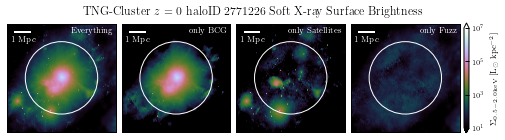

In [74]:
i = 16

central_key = central_keys[i]
haloID = haloIDs[i]

fig, axs = plot_soft_xray_components(central_key, haloID, savefig=False)

/tmp/ipykernel_6620/3828055787.py:17: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(wspace=0, hspace=0)


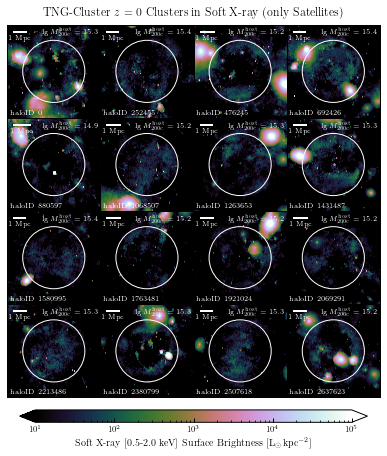

In [106]:
fig, axs = plt.subplots(4, 4, figsize=(figsizewidth,figsizewidth))

for i, ax in enumerate(axs.flatten()):

    central_key = central_keys[i]
    haloID = haloIDs[i]

    ax, img = add_xray_SB_ax(ax, central_key, haloID, key=Lx_map_4k_key_noBCG_nofuzz, add_infos=True)
    
cax = fig.add_axes([0.15, 0.075, 0.7, 0.025])
cbar = fig.colorbar(img, cax=cax, orientation='horizontal', extend='both')
cbar.set_label(r'Soft X-ray [0.5-2.0 keV] Surface Brightness [${\rm L_\odot\, kpc^{-2}}$]')
cbar.ax.tick_params(labelsize='small')

fig.suptitle('TNG-Cluster $z=0$ Clusters in Soft X-ray (only Satellites)', y=0.911)

fig.subplots_adjust(wspace=0, hspace=0)

if savefig:
    fname = '%s_snap099_%s_onlySatellites_mosaic.pdf'%(sim, Lx_key)
    for direc in direc_list:
        fig.savefig(direc + fname, bbox_inches='tight', dpi=300)


/tmp/ipykernel_6620/3015207642.py:17: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(wspace=0, hspace=0)


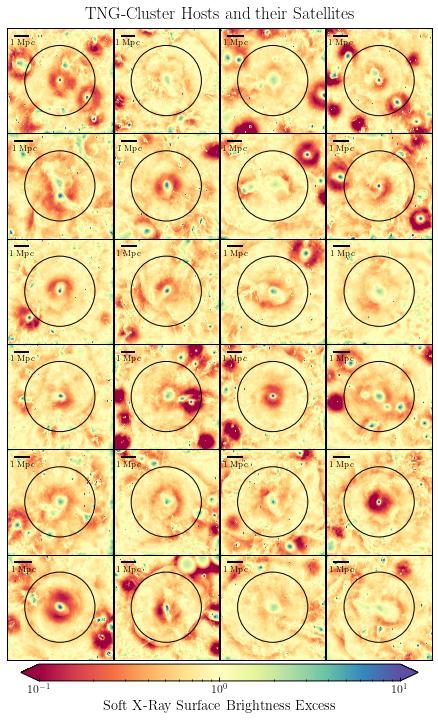

In [75]:
a0_width = 33.11
a0_height = 46.81
factor = 4
fig, axs = plt.subplots(6, 4, figsize=(a0_width / (factor + .2), a0_height / factor))
for i, ax in enumerate(axs.flatten()):
    central_key = central_keys[i]
    haloID = haloIDs[i]
    ax, img = add_xray_excess_ax(ax, central_key, haloID)

fig.suptitle('TNG-Cluster Hosts and their Satellites', fontsize='xx-large', y=0.9)

cax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
cbar = fig.colorbar(img, cax=cax, orientation='horizontal', extend='both')
cbar.set_label('Soft X-Ray Surface Brightness Excess', fontsize='x-large')
cbar.ax.tick_params(labelsize='large')

fig.subplots_adjust(wspace=0, hspace=0)

if savefig:
    fname = '%s_snap099_soft-xray-surfacebrightness-excess-poster.pdf'%sim
    for direc in direc_list:
        fig.savefig(direc + fname, bbox_inches='tight', dpi=600)

In [ ]:
import numpy as np
from astropy import units as u
import sys
h_const = 0.673 # Hubble constant
k_B_cgs = 1.38064852e-16 # boltzmann constant (CGS)
m_p_cgs = 1.6726219e-24 # proton mass [gram]
X_H = 0.76 # hydrogen mass fraction
gamma_gas = 5.0/3


def calculate_Xray_BolometricLum_Arepo(data):
    """ This function (Written by D. Nelson with minor modifications by M. Ayromlou) computes X-ray luminosity using Navarro+ (1995) Eqn. 6, the most basic estimator of bolometric X-ray luminosity in [10^30 erg/s] for individual gas cells, based only on their density and temperature. It assumes simplified (primordial) high-temp cooling function, and only free-free (bremsstrahlung) emission contribution from T>10^6 Kelvin gas. All inputs in code (Arepo) units. """

    # calculate mean molecular weight
    mu = calculate_mean_molecular_weight_Arepo(data).astype('float64')

    # calculate temperature (keV)
    temp = calculate_temperature_Arepo(data,unit='Kelvin')
    temp_Kelvin = temp * u.Kelvin
    temp_keV = temp_Kelvin.to(u.keV, equivalencies=u.temperature_energy()) / u.keV 

    # Eqn. 6
    mass_cgs = convert_units_Arepo(data['Masses'],quantity='mass',MAorCGS='CGS')
    rho_cgs = convert_units_Arepo(data['Density'],quantity='density',MAorCGS='CGS')

    L_x = (1.2e-24/ (mu**2)) * mass_cgs *  rho_cgs * np.sqrt(temp_keV)

    # clip any cells on eEOS (SFR>0) to zero
    dummy = np.where(data['StarFormationRate'] > 0.0)
    L_x[dummy] = 0.0

    # implement a linear ramp from log(T)=6.0 to log(T)=5.8 over which we clip to zero. This step is necessary to avoid having a non-zero X-ray luminosity for gas with T<10^6 K, which is not expected from Navarro+95 Eqn. 6.
    temp = np.log10(temp)
    L_x *= np.clip( (temp-5.8)/0.2, 0.0, 1.0 )

    L_x = np.array(L_x/1e30,dtype=np.float32) # work in this unit system of [10^30 erg/s] for xray to avoid overflows to inf

    return (L_x)


def calculate_mean_molecular_weight_Arepo(data):
    # mean molecular weight of the gas: see TNG FAQ webpage for details
    e_abund = data['ElectronAbundance']
    mu = 4*m_p_cgs/(1 + 3*X_H + 4*X_H*e_abund) # mean molecular weight
    return(mu)

def calculate_temperature_Arepo(data,unit='Kelvin'):
    # Temperature of the gas: see TNG FAQ webpage for details
    i_energy = data['InternalEnergy']
    mu = calculate_mean_molecular_weight_Arepo(data)
    gas_temp = (gamma_gas-1)*(i_energy/k_B_cgs)*mu*(10**10) # kelvin
    if unit != 'Kelvin':
        gas_temp = gas_temp * u.Kelvin
        if unit == 'keV':
            gas_temp = gas_temp.to(u.keV, equivalencies=u.temperature_energy()) / u.keV 
        elif unit == 'eV':
            gas_temp = gas_temp.to(u.eV, equivalencies=u.temperature_energy()) / u.eV
    return(gas_temp)


def convert_units_Arepo(data, quantity, tofromcode='fromcode', MAorCGS='MA'):
    """ This function converts units from Arepo units to my prefered units 
    * data: data
    * quantity [Arepo unit][my preferred unit]: mass [1e10Msun/h][Msun], scale[kpc/h][Mpc], density, density2d
    * tofromcode: tocode (convert from my units to code units), fromcode (convert from code units to my units)
    """
    
    if MAorCGS == 'MA':
        mass_conversion = 1e10/h_const
        scale_conversion = 1/(1000*h_const)
    elif MAorCGS == 'CGS':
        mass_conversion = (1e10/h_const)*1.989e33 
        scale_conversion = (3.086e24)/(1000*h_const)
    
    if quantity == 'mass':
        if tofromcode == 'fromcode':
            data = data*mass_conversion
        elif tofromcode == 'tocode':
            data = data/mass_conversion
    elif quantity == 'scale':
        if tofromcode == 'fromcode':
            data = data*scale_conversion
        elif tofromcode == 'tocode':
            data = data/scale_conversion
    elif quantity == 'density':
        if tofromcode == 'fromcode':
            data = data*mass_conversion/(scale_conversion**3)
        elif tofromcode == 'tocode':
            data = data*(scale_conversion**3)/mass_conversion
    elif quantity == 'density2d':
        if tofromcode == 'fromcode':
            data = data*mass_conversion/(scale_conversion**2)
        elif tofromcode == 'tocode':
            data = data*(scale_conversion**2)/mass_conversion
    else:
        print("Quantity not recognized")
        sys.exit()
            
    return(data)

In [ ]:
gas_fields = ['Masses', 'Coordinates', 'Density', 'GFM_Metallicity',
              'InternalEnergy', 'ElectronAbundance', 'StarFormationRate']

halo = il.groupcat.loadSingle(basePath, snapNum, haloID=haloID)
halo_gas_cells = il.snapshot.loadHalo(basePath, snapNum, haloID, gas_ptn, fields=gas_fields)
halo_gas_cells = ru.calc_temp_dict(halo_gas_cells)

In [ ]:
Lx_MA = calculate_Xray_BolometricLum_Arepo(halo_gas_cells)

In [ ]:
indices = Lx_MA > 0
plt.figure()
plt.hist(np.log10(Lx_MA[indices]) + 30)
plt.yscale('log')


In [ ]:
subset = il.snapshot.getSnapOffsets(basePath, snapNum, haloID, "Group")
start = subset['offsetType'][gas_ptn]
end = start +  subset['lenType'][gas_ptn]



In [ ]:
subset = il.snapshot.getSnapOffsets(basePath, snapNum, haloID, "Group")
start = subset['offsetType'][gas_ptn]
end = start +  subset['lenType'][gas_ptn]

direc = '/vera/ptmp/gc/dnelson/sims.TNG/L680n8192TNG/data.files/cache/'
fname = 'cached_gas_xray_lum_0.5-2.0kev_99.hdf5'
with h5py.File(direc + fname, 'r') as f:
    Lx_DN = f['xray_lum_0.5-2.0kev'][start:end]
    f.close()

In [ ]:
indices = Lx_DN > 0
plt.figure()
plt.hist(np.log10(Lx_DN[indices]) + 30)
plt.yscale('log')

In [ ]:
indices = Lx_MA > 0
y = Lx_MA[indices] / Lx_DN[indices]
x = Lx_DN[indices]
T = halo_gas_cells['Temperature'][indices]
rho = halo_gas_cells['Density'][indices] * 1.0e10 / h / (a / h)**3
Z = halo_gas_cells['GFM_Metallicity'][indices] / 0.0127

direc = '../Figures/TNGCluster/'
savefig=False

fig, axs = plt.subplots(2, 2, figsize=(figsizewidth, figsizewidth / 1.25))

xdsets = [np.log10(x) + 30, np.log10(T), np.log10(rho), np.log10(Z)]
xlabels = [r'$\log_{10}\, [L_{\rm 0.5-2\, keV}({\rm APEC}) / {\rm erg\, s^{-1}}]$',
           r'$\log_{10}\, [T_{\rm gas} / {\rm K}]$',
           r'$\log_{10}\, [\rho_{\rm gas} / {\rm M_\odot\, kpc^{-3}}]$',
           r'$\log_{10}\, [Z_{\rm gas} / {\rm Z_\odot}]$']

fig.suptitle(r'TNG-Cluster snap 099 halo %d gas ($%s$ cells)'%(haloID, ru.latex_float(x.size, 1)))
fig.supylabel(r'$\log_{10}\, [L_{\rm x}({\rm Navarro+95}) /L_{\rm 0.5-2\, keV}({\rm APEC})]$')

one_one_kwargs = dict(ls='-', marker='None', c='k', zorder=1.0, lw=2.5)

norm = mpl.colors.LogNorm(vmax=1.0e5)
bins = 500
Ncells_label = r'Number of Gas Cells'
for i, ax in enumerate(axs.flatten()):
    dset = xdsets[i]
    xlabel = xlabels[i]
    ax.set_xlabel(xlabel)

    vals = ax.hist2d(dset, np.log10(y), bins=bins, norm=norm, rasterized=True)
    ax.plot(ax.get_xlim(), [0, 0], **one_one_kwargs)

    
    cax = inset_axes(ax, width='50%', height='5%', loc='lower left')
    cbar = plt.colorbar(vals[3], cax=cax, orientation='horizontal')
    cbar.set_label(Ncells_label, labelpad=5, fontsize='small')
    cbar.ax.tick_params(labelsize='x-small')
    cax.xaxis.set_label_position('top')
    cax.xaxis.set_ticks_position('top')

if savefig:
    fname = '%s_snap099_haloID%08d_LxNavarro+95-LxAPEC_multipanel.pdf'%(sim, haloID)
    fig.savefig(direc + fname, bbox_inches='tight')

    